# Visualizing Iowan's consumption of liquor from 2014-2017 and around the 2016 Presendential Election

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import pyproj
import rasterio
import rasterstats
import matplotlib.patches as mpatches
import matplotlib.colors
import datetime
import time
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors

In [2]:
iowa=geopandas.read_file("IA_counties/IA_counties.shp") #read in Iowa shape file
iowa.NAME10=iowa.NAME10.str.lower() #lowercase all county names to make merging easier with the liquor dataset
pd.set_option('display.max_columns', None) #did this to see all columns in iowa.head()

In [3]:
iowa.columns

Index(['STATEFP10', 'COUNTYFP10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'N_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'TOTVOT00', 'PRES00D', 'PRES00R',
       'PRES00G', 'PRES00OTH', 'TOTVOT04', 'PRES04D', 'PRES04R', 'PRES04OTH',
       'TOTVOT08', 'PRES08D', 'PRES08R', 'PRES08OTH', 'TOTVOT12', 'PRES12D',
       'PRES12R', 'PRES12OTH', 'TOTVOT16', 'PRES16D', 'PRES16R', 'PRES16OTH',
       'CD', 'geometry'],
      dtype='object')

In [4]:
iowa['majD']=iowa.PRES16D>iowa.PRES16R #create boolean for MAJORITY DEMOCRATS (majD) for 2016
colors={True:'blue',False:'red'} #create color dict that will be used later for this column

In [5]:
iowa.loc[iowa['majD']]['NAME10'].value_counts()

polk          1
linn          1
johnson       1
story         1
black hawk    1
scott         1
Name: NAME10, dtype: int64

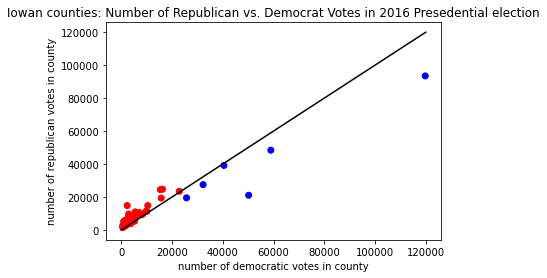

In [6]:
plt.scatter(x=iowa.PRES16D,y=iowa.PRES16R,c=iowa['majD'].map(colors));
plt.xlabel('number of democratic votes in county');
plt.ylabel('number of republican votes in county');
plt.title('Iowan counties: Number of Republican vs. Democrat Votes in 2016 Presedential election')
plt.plot([0,120000],[0,120000],color='black');


# The above chart is very important for a few reasons:
1. We see that larger populations tend to have a democratic majority
2. This will be an issue when looking at liquor sales because larger populations will almost certainly have higher liquor consumption because there are more people.
3. The way forward: try and do per capita consumption. If we don't democratic majority counties will look like they drink **A LOT**

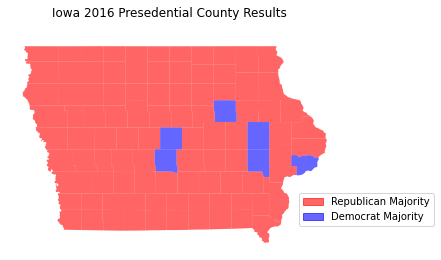

In [7]:
#just creating a map for republican vs. democratic majority counties. I verified it. It is correct
iowa.plot(color=iowa['majD'].map(colors),alpha=.6);
plt.suptitle('Iowa 2016 Presedential County Results');
dem=mpatches.Patch(color='blue', alpha=.6 ,label='Democrat Majority');
rep=mpatches.Patch(color='red', alpha=.6 ,label='Republican Majority');
plt.legend(handles=[rep,dem], loc='lower right',bbox_to_anchor=(1.29,.1));
plt.axis('off');
#next try to do it gradient w/ color scale 

In [8]:
iowa.columns

Index(['STATEFP10', 'COUNTYFP10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'N_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'TOTVOT00', 'PRES00D', 'PRES00R',
       'PRES00G', 'PRES00OTH', 'TOTVOT04', 'PRES04D', 'PRES04R', 'PRES04OTH',
       'TOTVOT08', 'PRES08D', 'PRES08R', 'PRES08OTH', 'TOTVOT12', 'PRES12D',
       'PRES12R', 'PRES12OTH', 'TOTVOT16', 'PRES16D', 'PRES16R', 'PRES16OTH',
       'CD', 'geometry', 'majD'],
      dtype='object')

In [9]:
xtra={'percR':0}
iowa=iowa.append(xtra,ignore_index=True)
xtra1={'percR':100}
iowa=iowa.append(xtra1,ignore_index=True)

In [10]:
iowa['percR']=(iowa.PRES16R/iowa.TOTVOT16)*100 #create column for percent of votes to Republicans
iowa['percD']=(iowa.PRES16D/iowa.TOTVOT16)*100 #create column for percent of votes to Democrats

In [11]:
iowa['percR_relD']=iowa.PRES16R/(iowa.PRES16R+iowa.PRES16D)

In [12]:
xtra={'percR_relD':0};
iowa=iowa.append(xtra,ignore_index=True);
xtra1={'percR_relD':1};
iowa=iowa.append(xtra1,ignore_index=True);

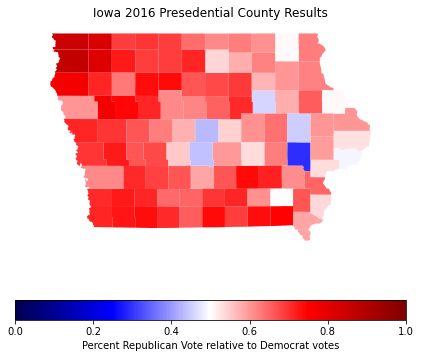

In [13]:
f,a=plt.subplots(figsize=(7,6));
plt.title('Iowa 2016 Presedential County Results');
iowa.plot(column='percR_relD',
         ax=a,
         cmap='seismic',
         legend=True,
         legend_kwds={'label': "Percent Republican Vote relative to Democrat votes",# this labels it.
                               'orientation': "horizontal"}); 

plt.axis('off');
plt.show();

# Consumption of liquor over time for Iowan counties based on party majority

In [14]:
iowa=iowa.drop(columns=['STATEFP10', 'COUNTYFP10', 'GEOID10','NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10','HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'N_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'TOTVOT00', 'PRES00D', 'PRES00R',
       'PRES00G', 'PRES00OTH', 'TOTVOT04', 'PRES04D', 'PRES04R', 'PRES04OTH',
       'TOTVOT08', 'PRES08D', 'PRES08R', 'PRES08OTH', 'TOTVOT12', 'PRES12D',
       'PRES12R','NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'PRES12OTH'])

In [15]:
#pop. of all democratic counties and republican counties, respectively 
x=iowa.loc[iowa.majD==True][['TOTPOP']]
x=sum(x.TOTPOP) #population of all democratic majority counties
y=iowa.loc[iowa.majD==False][['TOTPOP']]
y=sum(y.TOTPOP) #popoulation of all republican majority counties
z=round((x/(x+y))*100,2)
print('{}% is the percent of the population in Iowa that lives in the 6 Democratic majority counties in 2016'.format(z))

38.03% is the percent of the population in Iowa that lives in the 6 Democratic majority counties in 2016


In [16]:
monsale=pd.read_csv("monthly_county_sales.csv") #read in cleaned monthly liquor sale data

In [17]:
imsale=pd.merge(monsale,iowa,left_on='County',right_on='NAME10',indicator=True) #merge shape file and liquor sale data

In [18]:
repc=imsale.loc[imsale.majD==False] #create object for Republican majority counties 
demc=imsale.loc[imsale.majD==True] #create object for Democratic majority counties 

In [19]:
rep=repc.groupby(by='Date').sum('Sales (Dollars)') #monthly total sales of liquor for Republican majority counties
dem=demc.groupby(by='Date').sum('Sales (Dollars)') #monthly total sales of liquor for Democratic majority counties 
overall=imsale.groupby(by='Date').sum('Sales (Dollars)') #monthly total sales of liquor for all counties 

In [20]:
print(x+y>=3000000, x+y)

True 3046355.0


In [21]:
rep['Per_cap_liq_cons']=rep['Sales (Dollars)']/y #per capita consumption by month for Republican (Rep) counties ($/person every month)
dem['Per_cap_liq_cons']=dem['Sales (Dollars)']/x #per capita consumption by month for Democratic (Dem) counties ($/person every month)
overall['Per_cap_liq_cons']=overall['Sales (Dollars)']/(x+y)

In [22]:
rep['Per_cap_liq_cons'].mean() #average number of dollars per person spent each month on liquor in Rep counties

5.1667262114501975

In [23]:
overall['Per_cap_liq_cons'].mean()

6.755629434834886

In [24]:
dem['Per_cap_liq_cons'].mean() #average number of dollars per person spent each month on liquor in Dem counties
#Dem counties have significantly higher consumption per person. College towns???

9.344480887831486

## ALSO ADD IN OVERALL PER CAPITA CONSUMPTION 
-ADD SECOND Y AXIS IN WITH TOTAL OVERALL SALES 
-cHECK POPULATION TRENDS 
-Volumes vs dollars graph (make sure they're comparable)

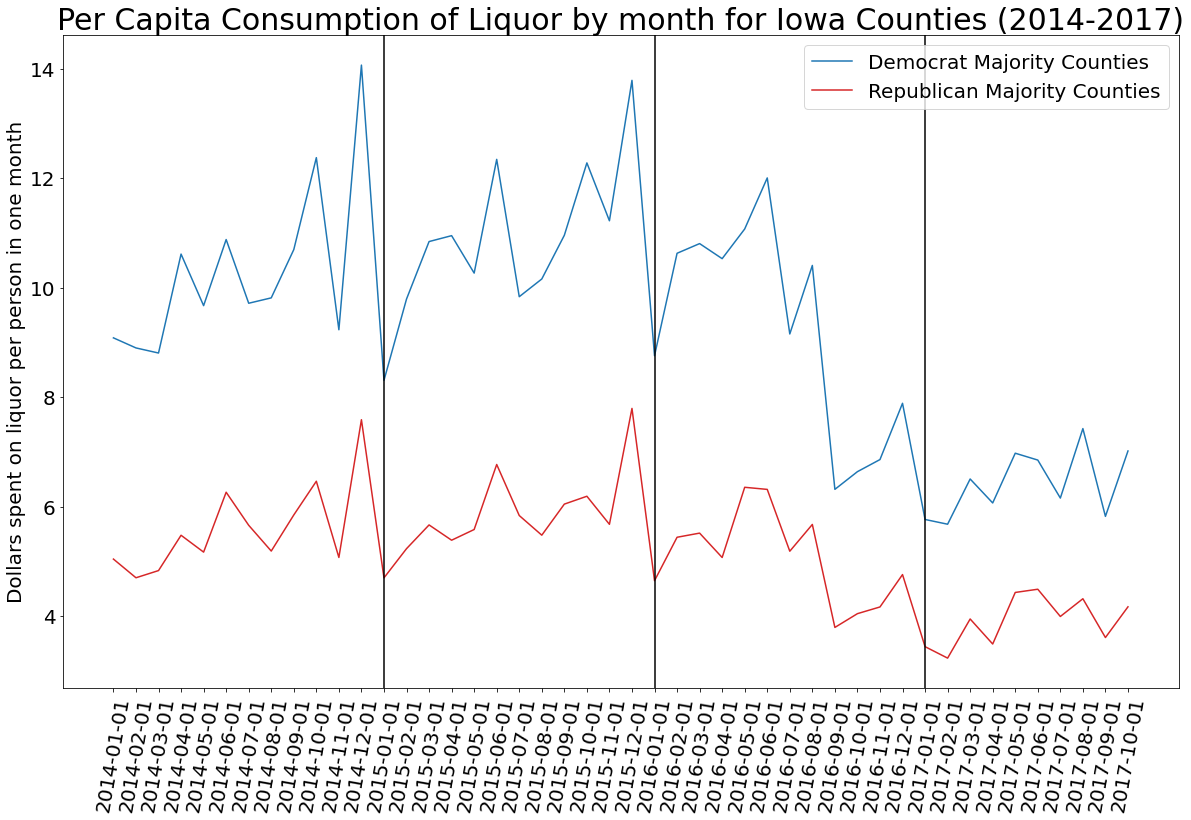

In [25]:
plt.figure(figsize=(20,12))
plt.plot(dem['Per_cap_liq_cons'], color='tab:blue',label='Democrat Majority Counties');
plt.plot(rep['Per_cap_liq_cons'],color='tab:red',label='Republican Majority Counties');
#plt.plot(overall['Per_cap_liq_cons'],color='tab:gray',label='All Iowan counties');
plt.legend(loc='upper right',bbox_to_anchor=(1,1),fontsize=20);
plt.title('Per Capita Consumption of Liquor by month for Iowa Counties (2014-2017)',fontsize=30);
plt.xticks(rotation=80,fontsize=20)
plt.ylabel('Dollars spent on liquor per person in one month',fontsize=20)
plt.yticks(fontsize=20,color='black')

xcoords=['2015-01-01','2016-01-01','2017-01-01']
colors=['k','k','k']
for xc,c in zip(xcoords,colors):
    plt.axvline(x=xc,c=c)
plt.show()

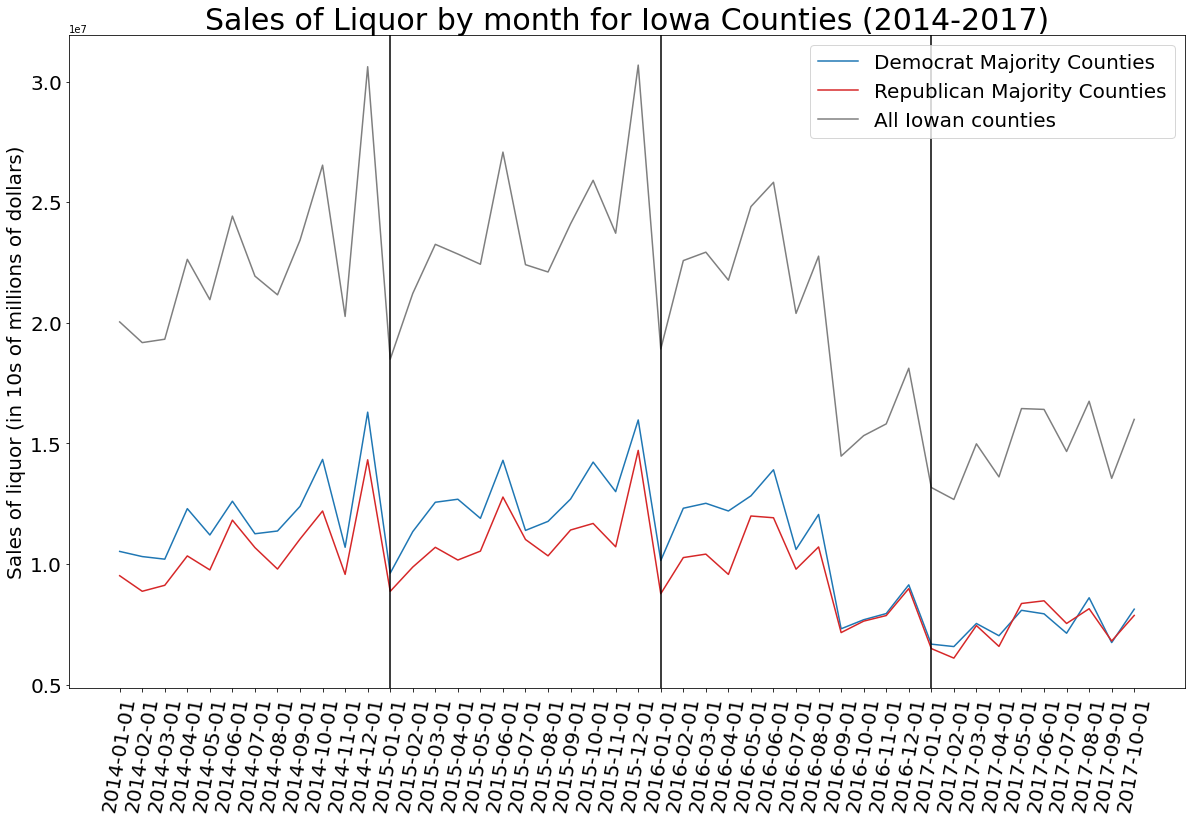

In [26]:
plt.figure(figsize=(20,12))
plt.plot(dem['Sales (Dollars)'], color='tab:blue',label='Democrat Majority Counties');
plt.plot(rep['Sales (Dollars)'],color='tab:red',label='Republican Majority Counties');
plt.plot(overall['Sales (Dollars)'],color='tab:gray',label='All Iowan counties');
plt.legend(loc='upper right',bbox_to_anchor=(1,1),fontsize=20);
plt.title('Sales of Liquor by month for Iowa Counties (2014-2017)',fontsize=30);
plt.xticks(rotation=80,fontsize=20)
plt.ylabel('Sales of liquor (in 10s of millions of dollars)',fontsize=20)
plt.yticks(fontsize=20,color='black')

xcoords=['2015-01-01','2016-01-01','2017-01-01']
colors=['k','k','k']
for xc,c in zip(xcoords,colors):
    plt.axvline(x=xc,c=c)
plt.show()

In [27]:
monthly_volume=pd.read_csv("monthly_county_volume_l.csv")

In [28]:
volume_overall=monthly_volume.groupby(by='Date').sum('Volume Sold (Liters)')

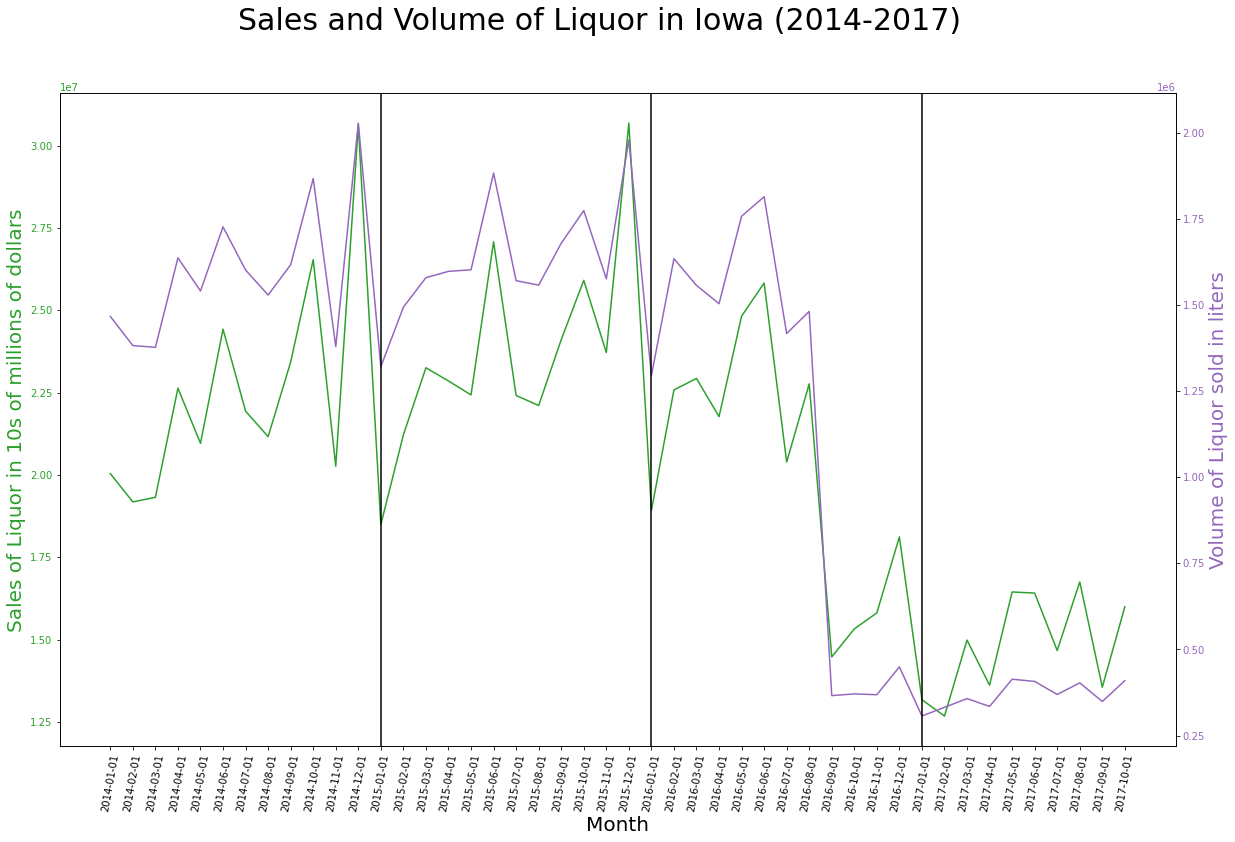

In [29]:
fig,ax1=plt.subplots(figsize=(20,12))
fig.suptitle('Sales and Volume of Liquor in Iowa (2014-2017)',fontsize=30)
ax1.set_xlabel('Month',fontsize=20)
ax1.set_ylabel('Sales of Liquor in 10s of millions of dollars',fontsize=20,color='tab:green')
ax1.plot(overall.index,overall['Sales (Dollars)'],c='tab:green')
ax1.tick_params(axis='y',labelcolor='tab:green')
plt.xticks(rotation=80)
ax2=ax1.twinx()
color='tab:purple'
ax2.set_ylabel('Volume of Liquor sold in liters',fontsize=20, color='tab:purple')
ax2.plot(overall.index,volume_overall['Volume Sold (Liters)'],color=color)
ax2.tick_params(axis='y',labelcolor='tab:purple')
xcoords=['2015-01-01','2016-01-01','2017-01-01']
colors=['k','k','k']
for xc,c in zip(xcoords,colors):
    plt.axvline(x=xc,c=c)
plt.show()

# Liquor Consumption around 2016 election 

In [30]:
dsale=pd.read_csv("daily_county_sales.csv") #read in daily sales of liquor 

In [31]:
dsale.Date=pd.to_datetime(dsale.Date)
dsale['dofweek']=dsale.Date.dt.day_name()

In [32]:
dsale['week']=dsale['Date'].dt.isocalendar().week #get the week number of the year
dsale['year']=dsale['Date'].dt.year #extract only year. 
#groupbying all of these columns will allow us to get the 
#weekly consumption of each week in each year

In [33]:
dsale

,Date,County,Sales (Dollars),dofweek,week,year
0,2014-01-02,allamakee,505.78,Thursday,1,2014
1,2014-01-02,black hawk,106479.37,Thursday,1,2014
2,2014-01-02,boone,4136.59,Thursday,1,2014
3,2014-01-02,carroll,29607.56,Thursday,1,2014
4,2014-01-02,cedar,4186.41,Thursday,1,2014
...,...,...,...,...,...,...
30845,2017-10-31,sac,9744.54,Tuesday,44,2017
30846,2017-10-31,sioux,20031.95,Tuesday,44,2017
30847,2017-10-31,warren,20881.10,Tuesday,44,2017
30848,2017-10-31,webster,989.62,Tuesday,44,2017


In [34]:
idsale=pd.merge(dsale,iowa,left_on='County',right_on='NAME10',indicator=True) #merge liquor sales with iowa county info

In [35]:
repc=idsale.loc[idsale.majD==False] #subset Rep counties
demc=idsale.loc[idsale.majD==True] #subset Dem counties 

In [36]:
elecweek=idsale.loc[idsale.Date=='2016-11-08']['week'][794] #selecting the week of the election for later.
elecweek

45

# BELOW WILL GIVE US THE WEEKLY AGGREGATE

In [37]:
repc=repc.groupby(['week','year']).agg({'Sales (Dollars)': ['sum'],'Date':[np.min,np.max]})
demc=demc.groupby(['week','year']).agg({'Sales (Dollars)': ['sum'],'Date':[np.min,np.max]})

In [38]:
repc['Per_cap_liq_cons']=repc['Sales (Dollars)']/y
demc['Per_cap_liq_cons']=demc['Sales (Dollars)']/x

In [39]:
repc=repc.reset_index() #had to reset index to have Date column to mess with
demc=demc.reset_index()

In [40]:
repc

week  year Sales (Dollars)       Date            Per_cap_liq_cons
                           sum       amin       amax                 
0      1  2014      1538881.93 2014-01-02 2014-12-31         0.815193
1      1  2016      2438202.60 2016-01-04 2016-01-07         1.291591
2      1  2017      1179269.48 2017-01-03 2017-01-06         0.624695
3      2  2014      2456324.30 2014-01-06 2014-01-09         1.301191
4      2  2015      2713189.88 2015-01-05 2015-01-08         1.437260
..   ...   ...             ...        ...        ...              ...
195   51  2016      2193924.22 2016-12-19 2016-12-23         1.162189
196   52  2014      2819995.72 2014-12-22 2014-12-27         1.493839
197   52  2015      3183304.38 2015-12-21 2015-12-26         1.686295
198   52  2016      2140751.76 2016-12-26 2016-12-30         1.134022
199   53  2015      2169491.54 2015-12-28 2015-12-31         1.149247

[200 rows x 6 columns]

In [41]:
repc['beg_week_date']=repc['Date']['amin']
demc['beg_week_date']=demc['Date']['amin']
repc['end_week_date']=repc['Date']['amax']
demc['end_week_date']=demc['Date']['amax']
demc=demc.drop(columns='Date')
repc=repc.drop(columns='Date')
repc=repc.sort_values(by=['year','week'])
demc=demc.sort_values(by=['year','week'])

C:\Users\brayd\anaconda3\envs\ace592\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [42]:
elecrep=repc.loc[repc.year!=2014]
elecdem=demc.loc[demc.year!=2014]

## DO CORRELATION OVER ALL TIME PERIODS B/T COUNTY TYPES AND THEN ALSO CLOSER TO ELECTION

In [43]:
elecrep['Sales (Dollars)'].corrwith(elecdem['Sales (Dollars)'])

sum    0.925748
dtype: float64

In [44]:
elecrep=elecrep.loc[(elecrep.beg_week_date>='2016-01-01')&(elecrep.beg_week_date<='2017-03-08')]
elecdem=elecdem.loc[(elecdem.beg_week_date>='2016-01-01')&(elecdem.beg_week_date<='2017-03-08')]

In [45]:
elecrep=elecrep.set_index('beg_week_date')
elecdem=elecdem.set_index('beg_week_date')

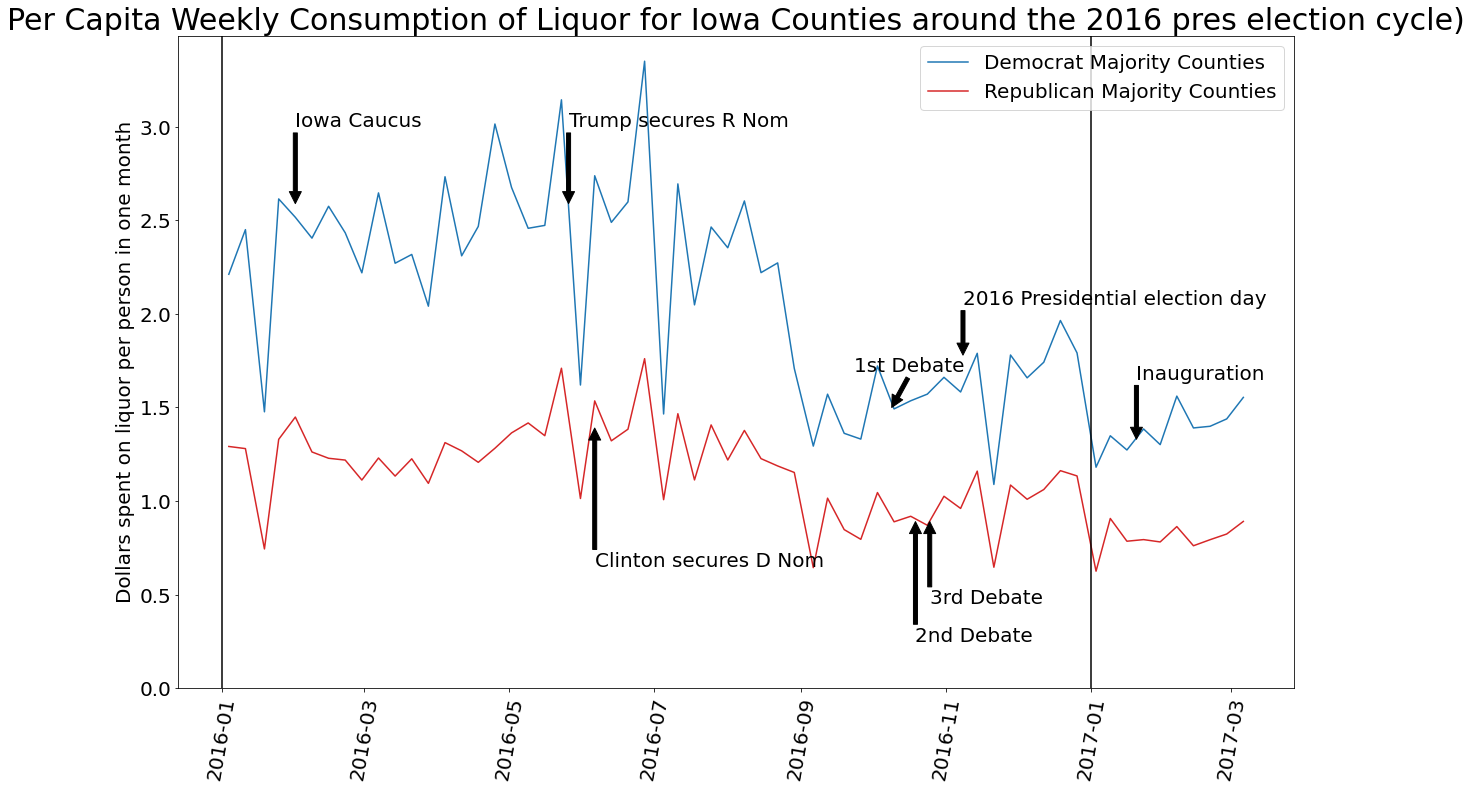

In [46]:
plt.figure(figsize=(20,12))
plt.plot(elecdem['Per_cap_liq_cons'],  color='tab:blue',label='Democrat Majority Counties');
plt.plot(elecrep['Per_cap_liq_cons'],color='tab:red',label='Republican Majority Counties');
plt.legend(loc='upper right',bbox_to_anchor=(1,1),fontsize=20);
plt.title('Per Capita Weekly Consumption of Liquor for Iowa Counties around the 2016 pres election cycle)',fontsize=30);
plt.xticks(rotation=80,fontsize=20)
plt.ylabel('Dollars spent on liquor per person in one month',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,)
xcoords=['2016-01-01','2017-01-01']
colors=['k','k']
for xc,c in zip(xcoords,colors):
    plt.axvline(x=xc,c=c)
    
plt.annotate('2016 Presidential election day', fontsize=20, xy=('2016-11-08',1.78), xytext=('2016-11-08',2.05),arrowprops=dict(facecolor="black"))
#plt.annotate('2016 Presidential election', fontsize=20, xy=('2016-11-08',1.0), xytext=('2016-12-08',0.5),arrowprops=dict(facecolor="black"))
plt.annotate('Iowa Caucus', fontsize=20, xy=('2016-02-01',2.59), xytext=('2016-02-01',3.0),arrowprops=dict(facecolor="black"))
plt.annotate('Trump secures R Nom', fontsize=20, xy=('2016-05-26',2.59), xytext=('2016-05-26',3.0),arrowprops=dict(facecolor="black"))
plt.annotate('Clinton secures D Nom', fontsize=20, xy=('2016-06-06',1.39), xytext=('2016-06-06',.65),arrowprops=dict(facecolor="black"))
plt.annotate('1st Debate', fontsize=20, xy=('2016-10-09',1.5), xytext=('2016-09-23',1.69),arrowprops=dict(facecolor="black"))
plt.annotate('2nd Debate', fontsize=20, xy=('2016-10-19',.89), xytext=('2016-10-19',.25),arrowprops=dict(facecolor="black"))
plt.annotate('3rd Debate', fontsize=20, xy=('2016-10-25',.89), xytext=('2016-10-25',.45),arrowprops=dict(facecolor="black"))    
#plt.annotate('Iowa State Fair', fontsize=20, xy=('2015-08-13',.89), xytext=('2015-08-13',.45),arrowprops=dict(facecolor="black"))  #didn't include 2015  
plt.annotate('Inauguration', fontsize=20, xy=('2017-01-20',1.33), xytext=('2017-01-20',1.65),arrowprops=dict(facecolor="black"))    

plt.show()

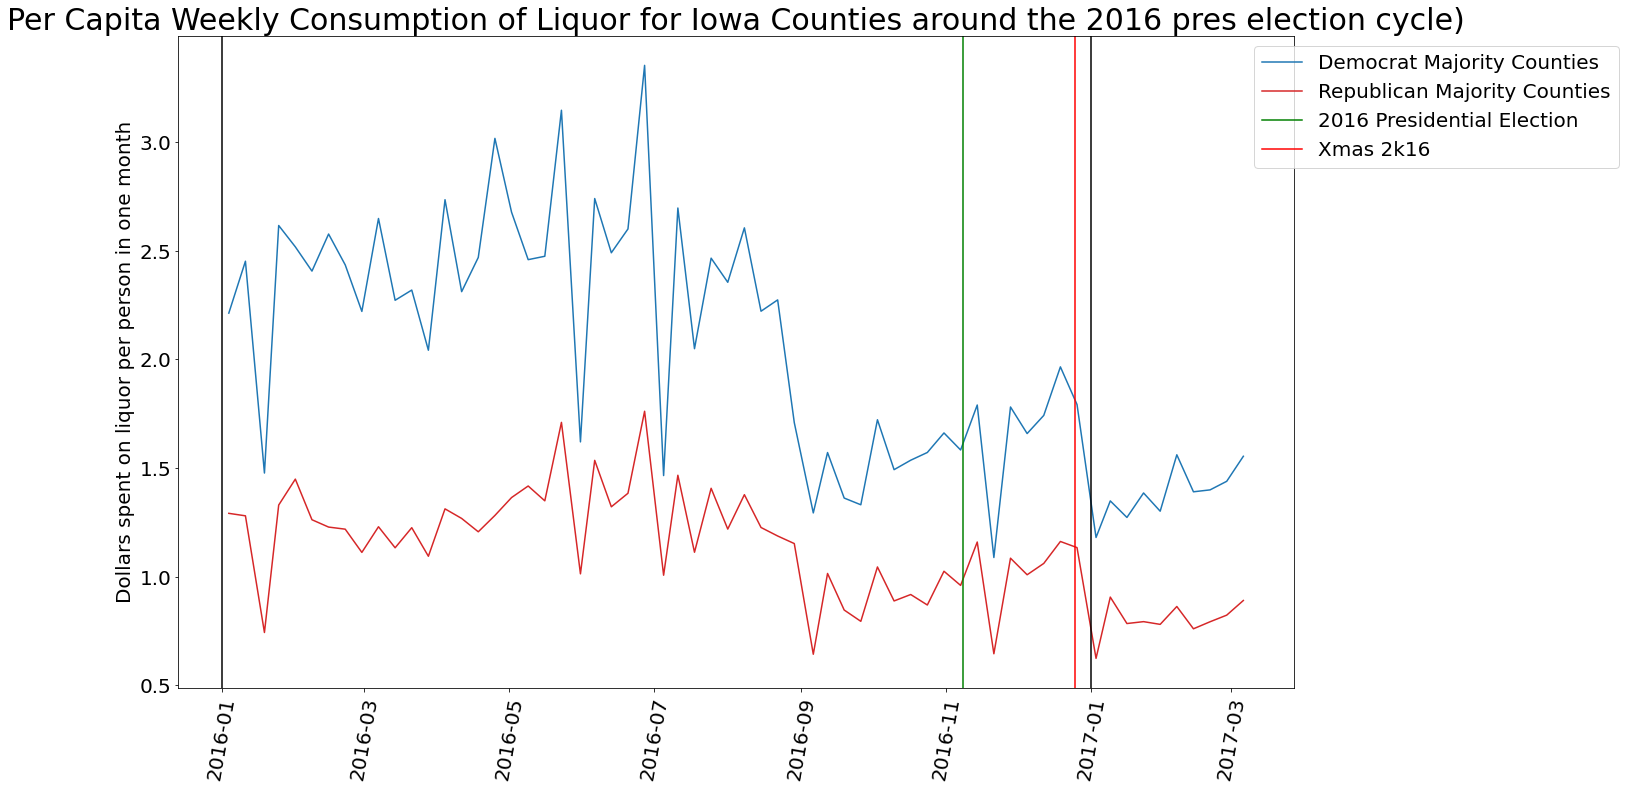

In [47]:
plt.figure(figsize=(20,12))
plt.plot(elecdem['Per_cap_liq_cons'],  color='tab:blue',label='Democrat Majority Counties');
plt.plot(elecrep['Per_cap_liq_cons'],color='tab:red',label='Republican Majority Counties');
plt.title('Per Capita Weekly Consumption of Liquor for Iowa Counties around the 2016 pres election cycle)',fontsize=30);
plt.xticks(rotation=80,fontsize=20)
plt.ylabel('Dollars spent on liquor per person in one month',fontsize=20)
plt.yticks(fontsize=20)

xcoords=['2016-01-01','2017-01-01']
colors=['k','k']
for xc,c in zip(xcoords,colors):
    plt.axvline(x=xc,c=c)
    
xcoords=['2016-11-08','2016-12-25']
label=['2016 Presidential Election','Xmas 2k16']
colors=['green','red']
for xc,c,z in zip(xcoords,colors,label):
    plt.axvline(x=xc,c=c,label='{}'.format(z))
    
plt.legend(loc='upper right',bbox_to_anchor=(1.3,1),fontsize=20)
plt.show()